# 📚 Student Habits vs Academic Performance: A Regression Modeling Approach

This notebook explores the relationship between student lifestyle habits — such as study hours, sleep duration, mobile usage, and class attendance — and their academic performance. The objective is to predict a **continuous academic performance score** based on these behavioral features.

We approach this as a **regression problem**, where the target variable represents a numerical performance metric.

### 🧪 Modeling Plan:

1. **Linear Regression Model (Baseline)**  
   We begin with a linear regression model to establish a simple, interpretable baseline. This helps us understand how much of the variation in performance can be explained by a linear combination of input features.

2. **Neural Network Regression Model**  
   We then train a feedforward neural network, which introduces non-linearities and allows the model to capture more complex patterns in the data that a linear model may miss.

### 📏 Evaluation Metric:

Model performance will be evaluated using standard regression metrics such as:

- **Mean Squared Error (MSE)**
- **Mean Absolute Error (MAE)**
- **R² Score (Coefficient of Determination)**

This comparison will help us assess whether the added complexity of a neural network offers significant improvements over a simpler linear baseline.

### Dataset

Dataset downloaded from [here](https://www.kaggle.com/datasets/jayaantanaath/student-habits-vs-academic-performance).

---

### Imports

In [1]:
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader

import matplotlib
import matplotlib.pyplot as plt

import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import seaborn as sns

import numpy as np

### Loading Data

In [2]:
data = pd.read_csv("student_habits_performance.csv")

### Visualising Data

In [3]:
data.head()

,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,S1000,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Master,Average,8,Yes,56.2
1,S1001,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,High School,Average,8,No,100.0
2,S1002,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,High School,Poor,1,No,34.3
3,S1003,23,Female,1.0,3.9,1.0,No,71.0,9.2,Poor,4,Master,Good,1,Yes,26.8
4,S1004,19,Female,5.0,4.4,0.5,No,90.9,4.9,Fair,3,Master,Good,1,No,66.4


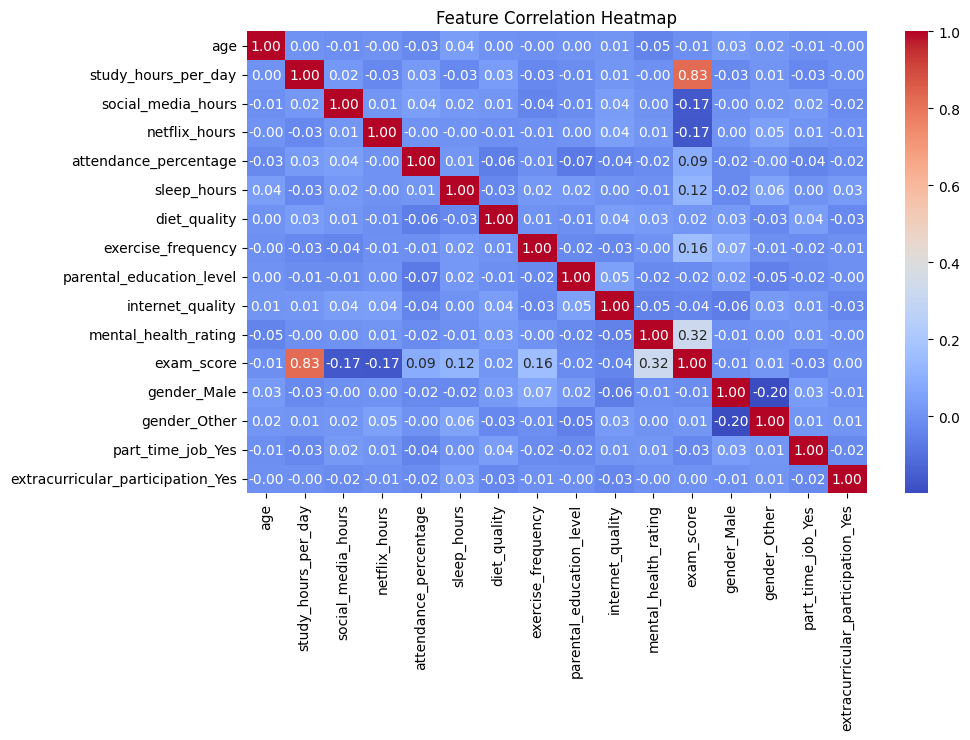

In [4]:
# Removing Student_ID as a feature
data = data.drop("student_id",axis=1)

# Using One hot encoding for gender

data = pd.get_dummies(data,columns=["gender","part_time_job","extracurricular_participation"],drop_first=True)
bool_cols = data.select_dtypes(include='bool').columns
data[bool_cols] = data[bool_cols].astype(int)

# Mapping categorical values
data["diet_quality"] = data["diet_quality"].map({"Poor":0,"Fair":1,"Good":2})
data["internet_quality"] = data["internet_quality"].map({"Poor":0,"Average":1,"Good":2})
data["parental_education_level"] = data["parental_education_level"].map({"High School":1,"Bachelor":2,"Master":3})
data["parental_education_level"] = data["parental_education_level"].fillna(0)

data.head()

plt.figure(figsize=(10,6))
sns.heatmap(data.corr(),annot=True,cmap="coolwarm",fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

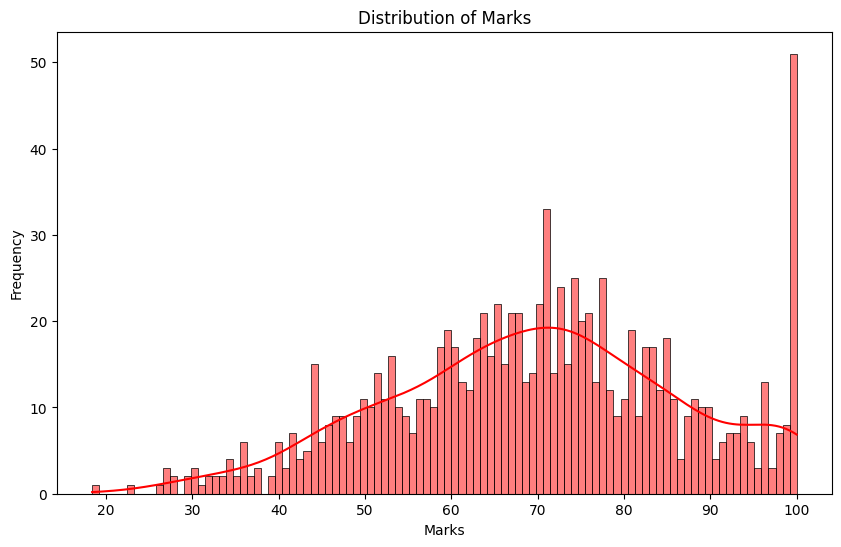

In [5]:
# Grade Distribution
plt.figure(figsize=(10,6))
sns.histplot(data["exam_score"],bins=100,kde=True, color="red")
plt.title("Distribution of Marks")
plt.xlabel("Marks")
plt.ylabel("Frequency")
plt.show()

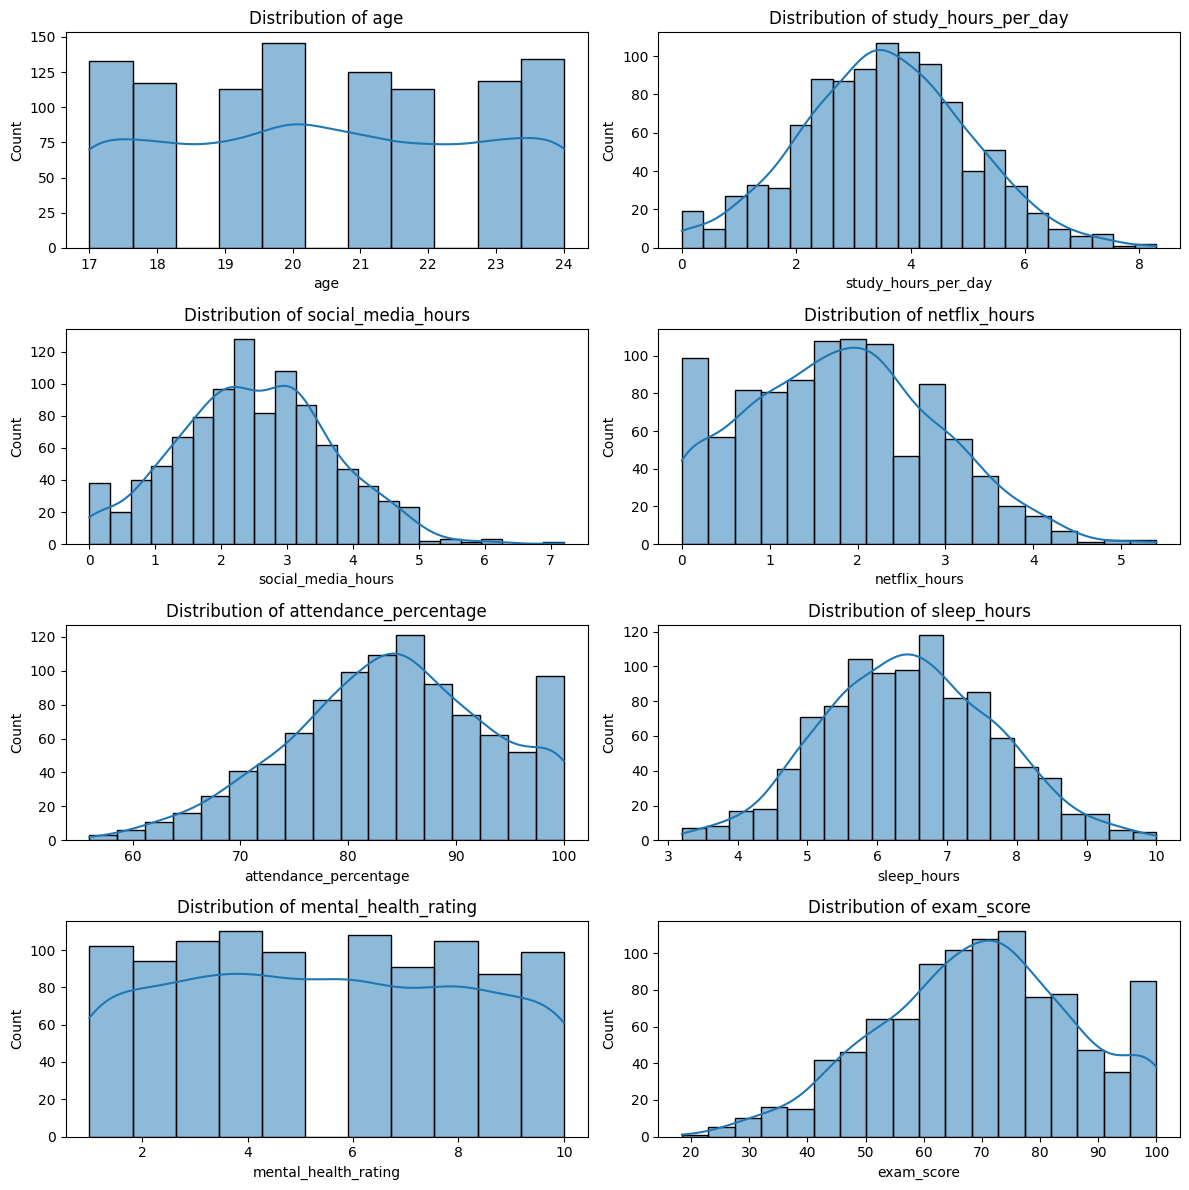

In [6]:
# distribution of numerical features
numerical_cols = ['age', 'study_hours_per_day', 'social_media_hours', 'netflix_hours', 
                  'attendance_percentage', 'sleep_hours', 'mental_health_rating', 'exam_score']

fig, axes = plt.subplots(4, 2, figsize=(12, 12))  # larger figsize for readability
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.histplot(data[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

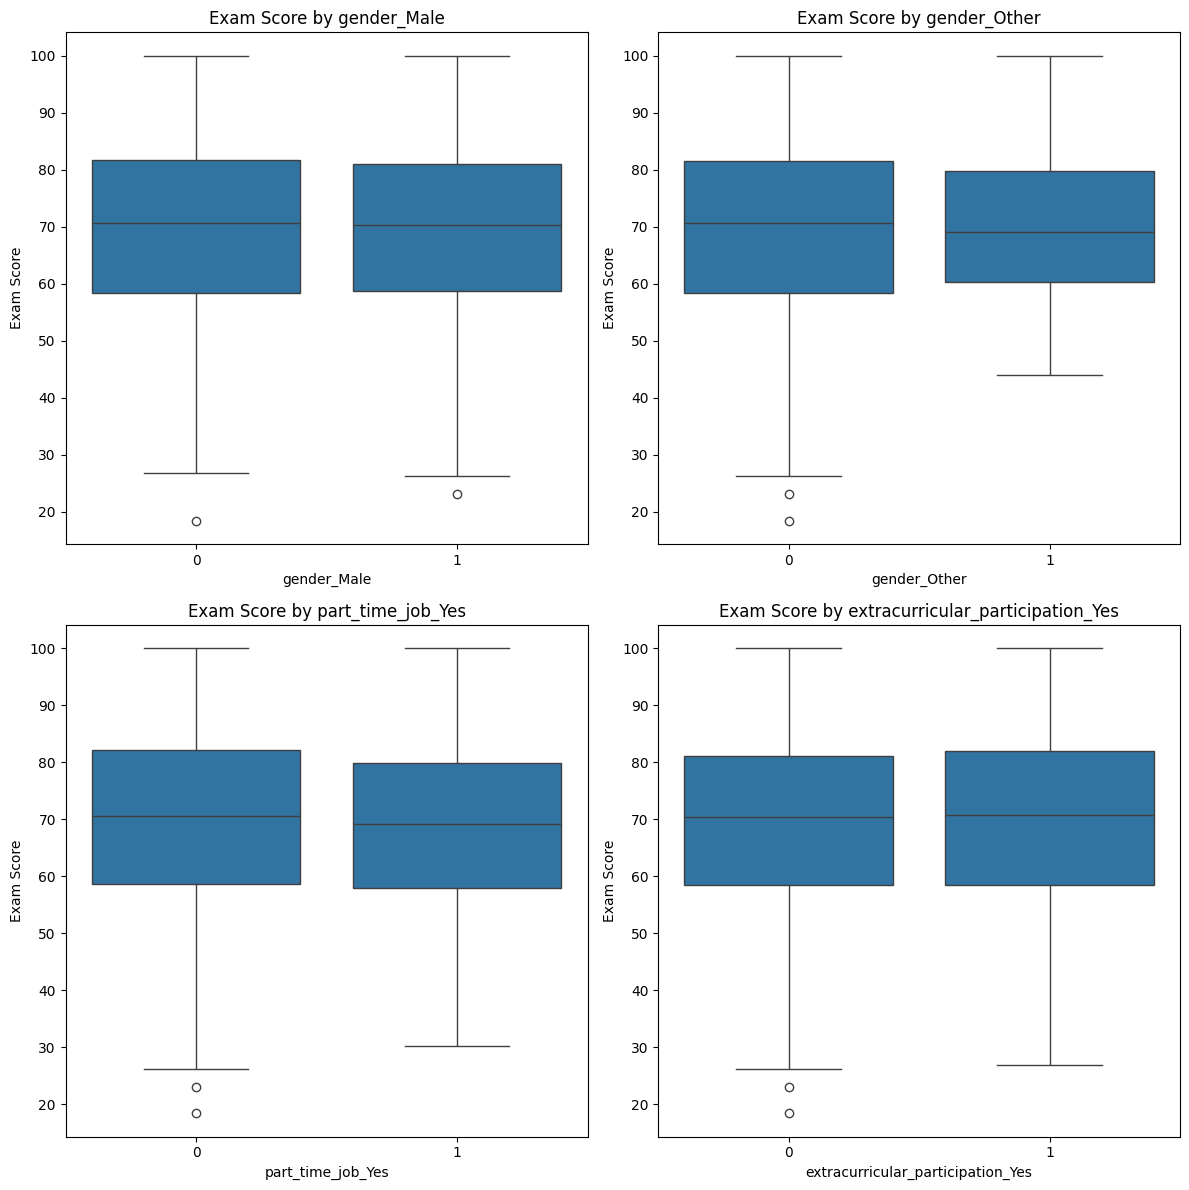

In [7]:
# Boxplots for Numerical vs Categorical
categorical_cols = ['gender_Male', 'gender_Other', 'part_time_job_Yes', 'extracurricular_participation_Yes']

fig, axes = plt.subplots(2, 2, figsize=(12, 12))  # larger figsize for readability
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.boxplot(x=data[col], y=data['exam_score'], ax=axes[i])
    axes[i].set_title(f'Exam Score by {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Exam Score')

plt.tight_layout()
plt.show()

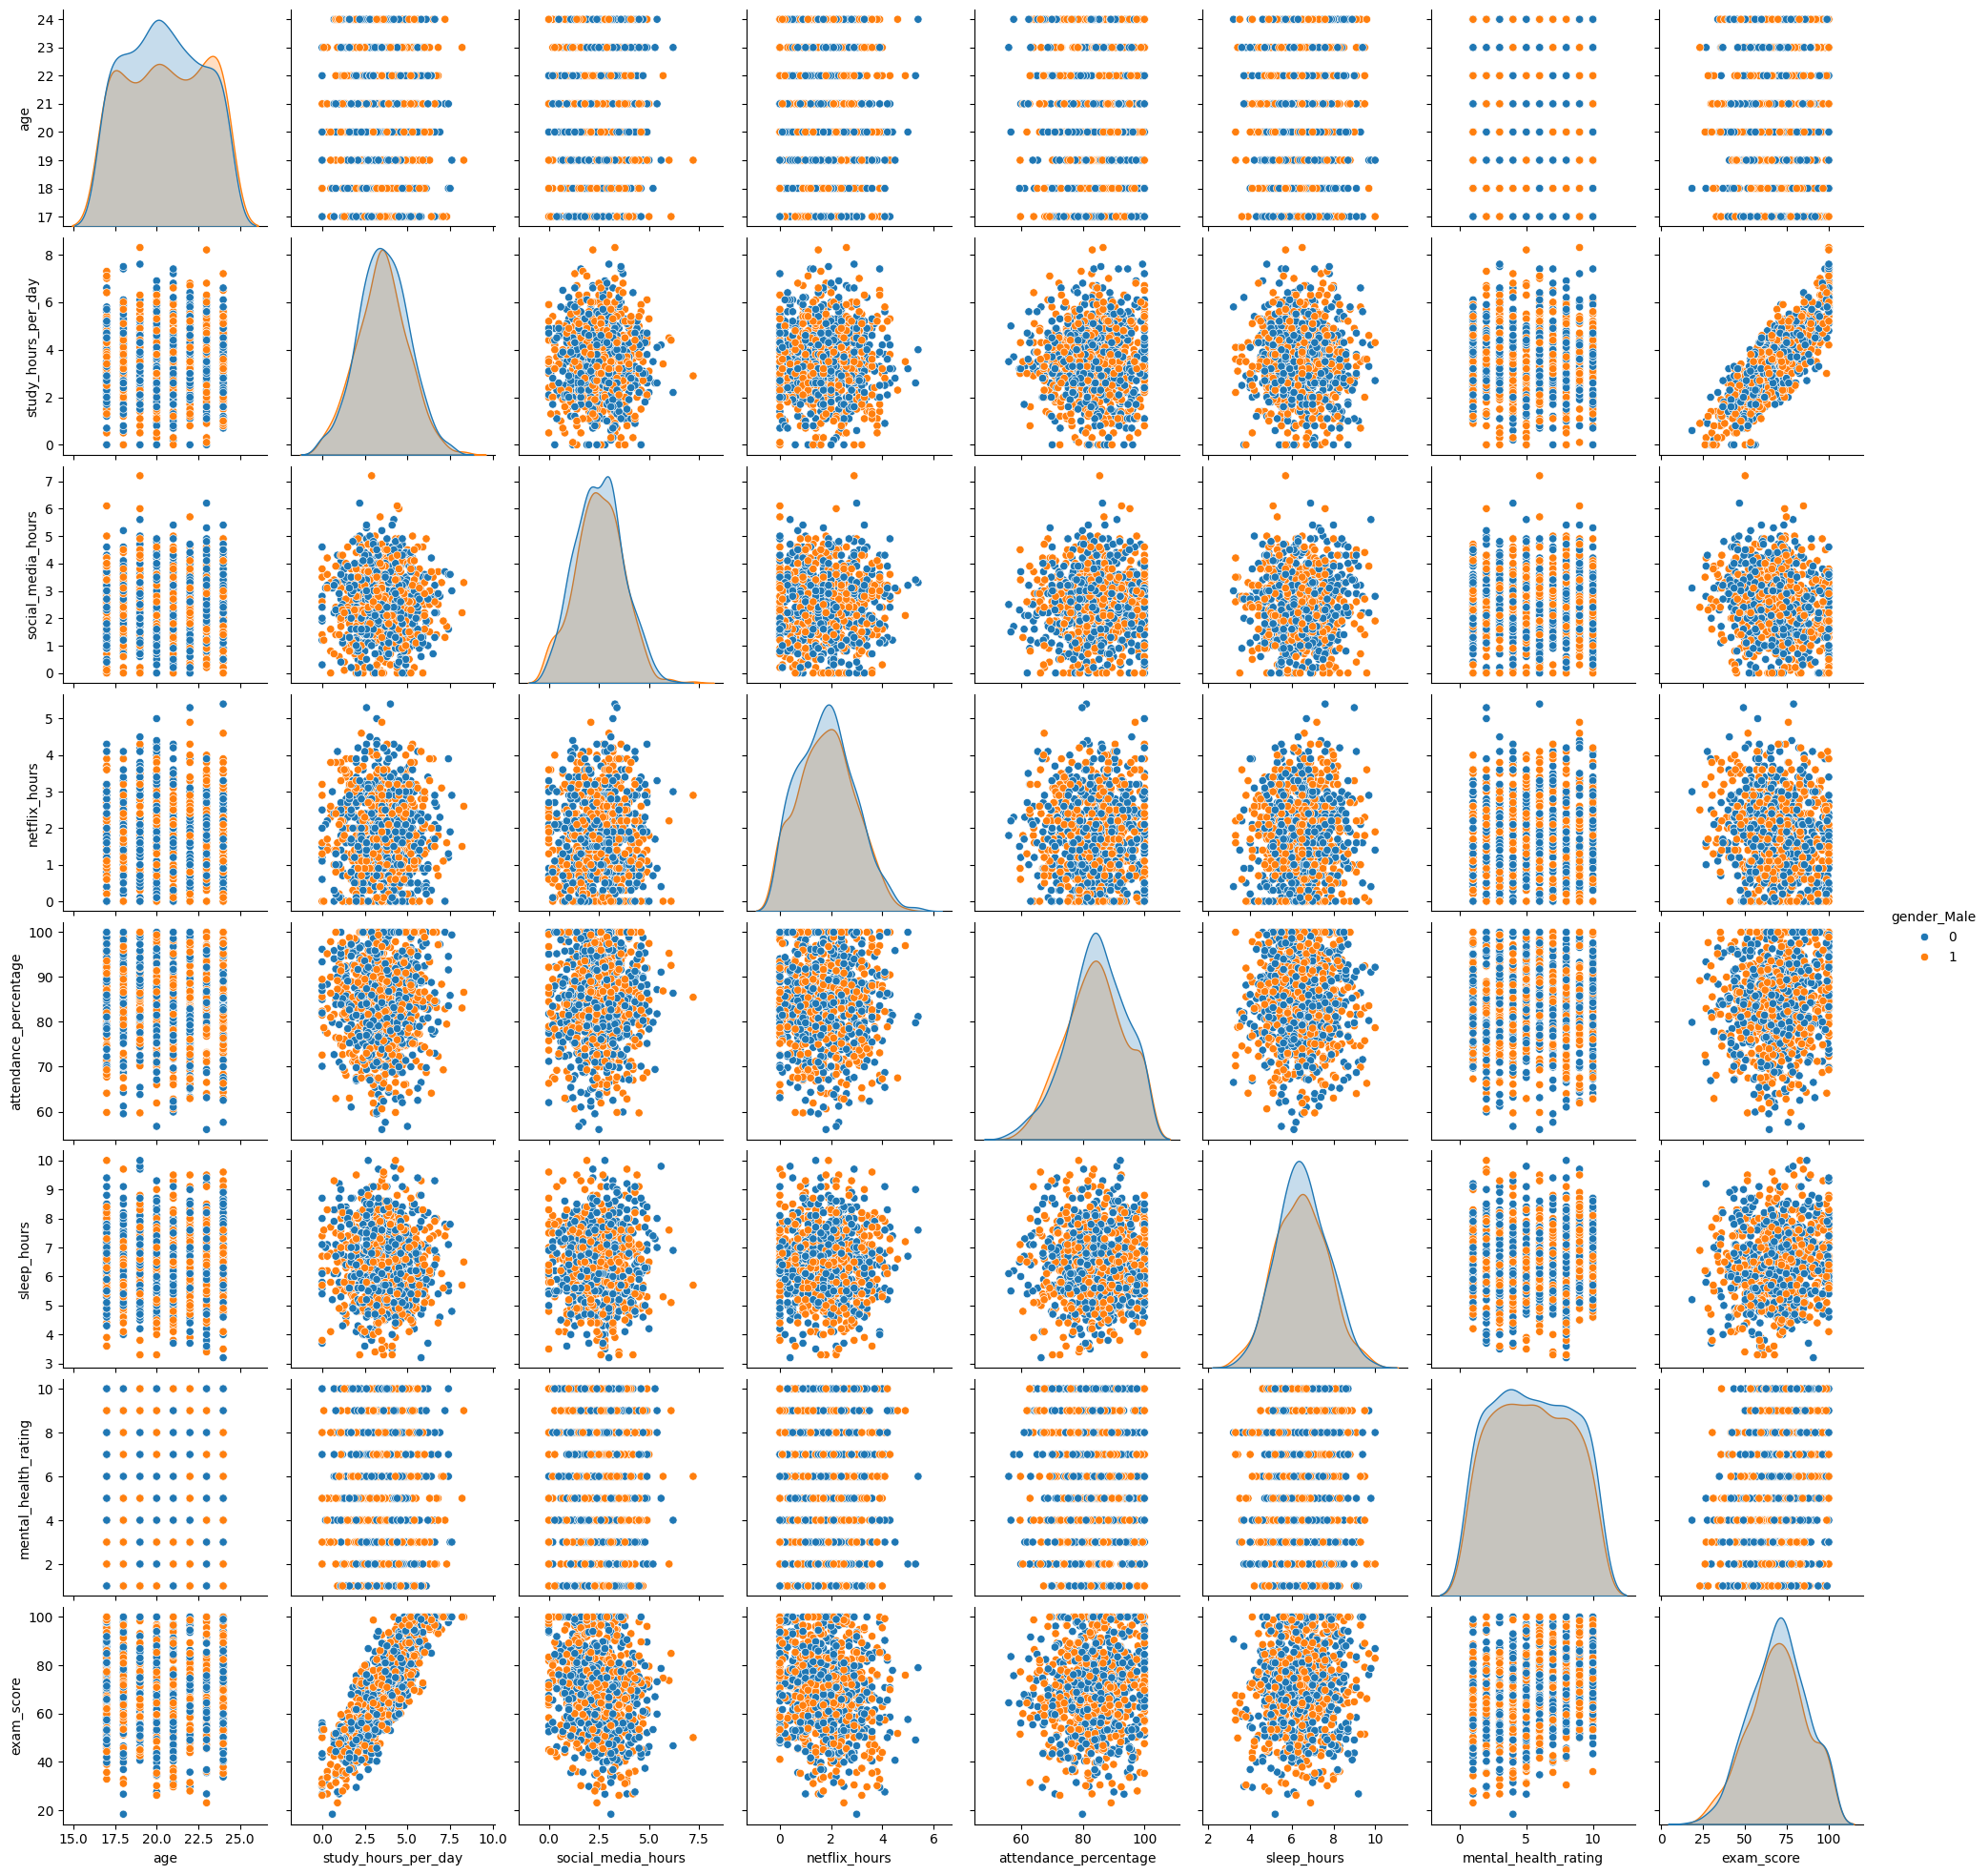

In [8]:
# Some pairplots
sns.pairplot(data, vars=numerical_cols, hue='gender_Male')  # or original gender column
plt.show()

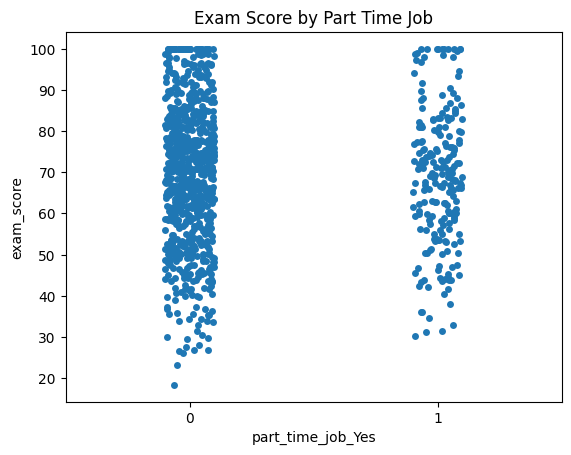

In [9]:
sns.stripplot(x=data['part_time_job_Yes'], y=data['exam_score'], jitter=True)
plt.title('Exam Score by Part Time Job')
plt.show()

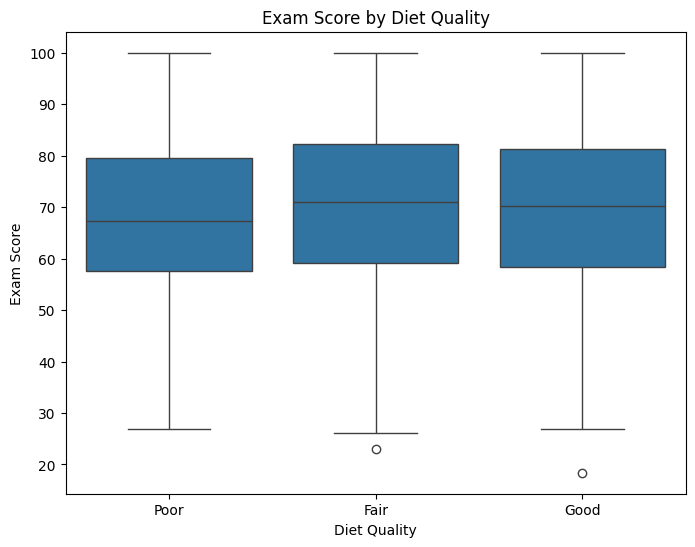

In [10]:
diet_labels = {0: 'Poor', 1: 'Fair', 2: 'Good'}

plt.figure(figsize=(8,6))
sns.boxplot(x=data['diet_quality'].map(diet_labels), y=data['exam_score'], order=['Poor', 'Fair', 'Good'])
plt.title('Exam Score by Diet Quality')
plt.xlabel('Diet Quality')
plt.ylabel('Exam Score')
plt.show()

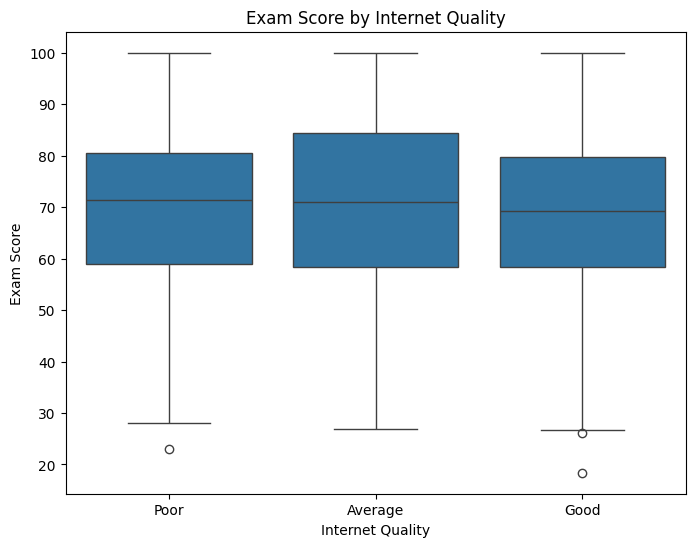

In [11]:
internet_labels = {0:"Poor",1:"Average",2:"Good"}

plt.figure(figsize=(8,6))
sns.boxplot(x=data['internet_quality'].map(internet_labels), y=data['exam_score'], order=['Poor', 'Average', 'Good'])
plt.title('Exam Score by Internet Quality')
plt.xlabel('Internet Quality')
plt.ylabel('Exam Score')
plt.show()

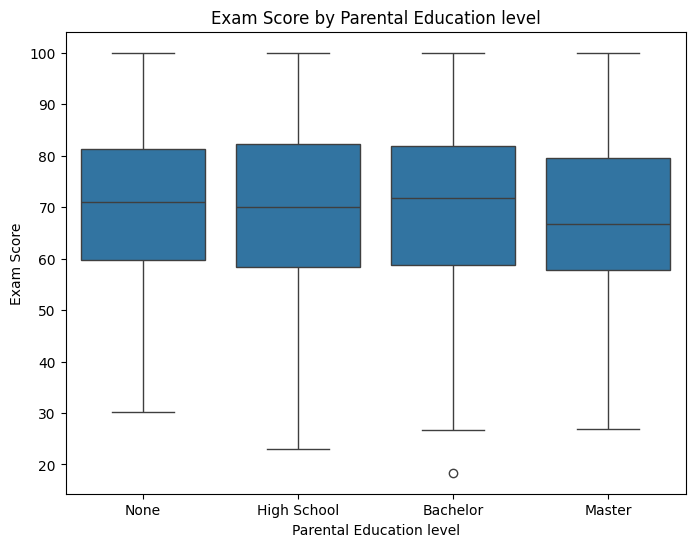

In [12]:
edu_labels = {0:"None",1:"High School",2:"Bachelor",3:"Master"}

plt.figure(figsize=(8,6))
sns.boxplot(x=data['parental_education_level'].map(edu_labels), y=data['exam_score'], order=['None', 'High School', 'Bachelor', "Master"])
plt.title('Exam Score by Parental Education level')
plt.xlabel('Parental Education level')
plt.ylabel('Exam Score')
plt.show()

### Training And Evaluating Linear Regression Model

In [20]:
# Define split sizes
total_samples = len(data)
train_end = int(0.9 * total_samples)  # 90% for training

# Manual Split
train_data = data.iloc[:train_end]  # First 90%
test_data = data.iloc[train_end:]  # Last 10%

# Separate Features (X) and Target (y)
X_train, y_train = train_data.drop(columns=["exam_score"]), train_data["exam_score"]
X_test, y_test = test_data.drop(columns=["exam_score"]), test_data["exam_score"]

# Print dataset shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (900, 15)
X_test shape: (100, 15)
y_train shape: (900,)
y_test shape: (100,)


In [21]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [22]:
#View Parameters

b = linear_model.intercept_
w = linear_model.coef_
print(f"w = {w:}, b = {b:0.2f}")

w = [-0.05210582  9.56420005 -2.57584678 -2.3560693   0.13777892  1.95129552
 -0.06206019  1.43126711  0.10893878 -0.20293153  1.93163761  0.25571109
  1.0906397   0.25716307 -0.24717952], b = 8.42


In [38]:
y_train_pred = linear_model.predict(X_train)
y_test_pred = linear_model.predict(X_test)

# Function to calculate errors
def calculate_errors(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"{dataset_name} Errors:")
    print(f"   - MAE      : {mae:.4f}")
    print(f"   - MSE      : {mse:.4f}")
    print(f"   - R² Score : {r2:.4f}")

# Calculate errors for each set
calculate_errors(y_train, y_train_pred, "Training Set")
calculate_errors(y_test, y_test_pred, "Test Set")

Training Set Errors:
   - MAE      : 196.2912
   - MSE      : 38824.6722
   - R² Score : -132.9305
Test Set Errors:
   - MAE      : 193.7549
   - MSE      : 37803.5691
   - R² Score : -157.1523


/Users/sanchaysingh/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/Users/sanchaysingh/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/sanchaysingh/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/sanchaysingh/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
/Users/sanchaysingh/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/Users/sanchaysingh/Library/Python